#### **0. References**



1. **ChatGPT**: acting as the masked autoencoder for my masked understanding.


#### **1. Libraries**

In [1]:
# Standard Library Imports
import sys
import os
import random
import pathlib
import time
import copy
from collections import Counter

# Third-Party Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import mean_squared_error


In [2]:
## GPU check and version check ##
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
print( 'python version : ',sys.version) 
print( 'torch version  : ',torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB
python version :  3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
torch version  :  2.5.1+cu121


#### **2. General utils**

In [3]:
## Utility Functions ##
def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True,warn_only=False)

def mean_std(train_dataset, device):
    train_dataloader = DataLoader(train_dataset, batch_size=4096, shuffle=False)
    train_data = []

    for lr_image_batch,_ in tqdm(train_dataloader):
        lr_image_batch = lr_image_batch.to(device)
        train_data.append(lr_image_batch)
    
    train_data = torch.cat(train_data, dim=0)
    mean = train_data.mean()
    std = train_data.std()

    return mean, std

def visualize_random_pairs_side_by_side(dataset, num_pairs=3):
    """
    Display 'num_pairs' randomly chosen LR-HR pairs side by side in a smaller,
    high-quality figure. Resizes the LR images to match the HR dimensions so
    both can be directly compared in one frame.
    
    Args:
        dataset (Dataset): An instance of CustomDataset (or any dataset returning (LR, HR) pairs).
        num_pairs (int): Number of random LR-HR pairs to visualize.
    """
    # Randomly pick indices
    indices = random.sample(range(len(dataset)), num_pairs)
    
    for i, idx in enumerate(indices, start=1):
        lr_img, hr_img = dataset[idx]
        
        # Convert tensors to NumPy arrays
        lr_np = lr_img.squeeze().detach().cpu().numpy()
        hr_np = hr_img.squeeze().detach().cpu().numpy()
        
        # Resize LR to match HR shape for side-by-side display
        lr_resized = resize(lr_np, hr_np.shape, anti_aliasing=True)
        
        # Concatenate horizontally
        # The resulting image has shape: (height, width_LR + width_HR)
        side_by_side = np.hstack((lr_resized, hr_np))
        
        # Show the combined image
        plt.figure(figsize=(8, 4), dpi=150)  # Smaller figure with higher DPI
        plt.imshow(side_by_side, cmap='gray')  # Display as grayscale
        plt.title(f"Pair #{i}: LR (left) | HR (right)")
        plt.axis('off')
        plt.show()

# Function to visualize the images
def visualize_images(lr_image, sr_image, hr_image):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='gray')
    plt.title("Low-Resolution Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sr_image, cmap='gray')
    plt.title("Super-Resolution Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(hr_image, cmap='gray')
    plt.title("High-Resolution Target")
    plt.axis('off')

    plt.show()

def plot_loss(train_loss, val_loss, save_path="figures/taskIVB_loss_curve.png"):
    # Set plot style within the function (local to this plot only)
    sns.set(style='whitegrid', context='paper', font_scale=1.4, rc={'axes.edgecolor': 'black', 'axes.linewidth': 1.2})
    plt.rc('font', family='serif', size=12)

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6), dpi=300)

    # Define visually appealing colors
    colors = ['crimson', 'navy']

    plt.plot(epochs, train_loss, label=f"Training Loss", color=colors[0], linewidth=2.5)
    plt.plot(epochs, val_loss, label=f"Validation Loss", color=colors[1], linewidth=2.5, linestyle='--')

    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')

    plt.legend(loc="upper right", fontsize=11, frameon=True, shadow=True)

    plt.grid(alpha=0.3)

    # Adjust axis limits dynamically with margin
    all_losses = train_loss + val_loss
    min_loss, max_loss = min(all_losses), max(all_losses)
    margin = (max_loss - min_loss) * 0.1
    plt.ylim(min_loss - margin, max_loss + margin)

    plt.tight_layout()

    # Create directory if it doesn't exist
    dir_name = os.path.dirname(save_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

#### **3. Dataset utils**

In [4]:
class CustomDataset(Dataset): # inherits from torch.utils.data.Dataset class
    def __init__(self, target_dir, transform=None):
        self.target_dir = target_dir
        lr_images_path = os.path.join(target_dir, 'LR')    
        self.paths = [os.path.join(lr_images_path, file) for file in os.listdir(lr_images_path) if file.endswith('.npy')]
        # get all paths of low-resolution images in the target directory
        self.transform = transform
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        lr_img_path = self.paths[index]
        filename = os.path.basename(lr_img_path)

        lr_img = np.load(lr_img_path) # (1,75,75)      
        lr_img = torch.tensor(lr_img, dtype=torch.float32)

        hr_img_path = os.path.join(self.target_dir, 'HR', filename)
        hr_img = np.load(hr_img_path) # (1,150,150)
        hr_img = torch.tensor(hr_img, dtype=torch.float32)
        

        if self.transform:
            lr_img = self.transform(lr_img)
        
        return lr_img, hr_img # (1,75,75), (1,150,150)  

#### **4. Training utils** 

In [22]:
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, pred, target):
        # Element-wise difference
        diff = pred - target
        
        # Compute Charbonnier loss
        loss = torch.sqrt(diff * diff + self.eps * self.eps)
        
        # Return the average loss
        return torch.mean(loss)

class Trainer:
    def __init__(self, model, device, HP ):
        self.model = model
        self.device =device
        self.epochs = HP['num_epochs']
        self.batch_size = HP['batch_size']
        self.lr = HP['lr']
        self.weight_decay = HP['weight_decay']
    
    def model_train(self, train_loader, val_loader):

        criterion = nn.MSELoss()
        # criterion = CharbonnierLoss()

        optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        print( "Training started...") 

        train_losses = []
        val_losses = []  
        
        for epoch in range(self.epochs):
            self.model.train() 

            running_loss = 0.0  
            total_batches = 0 

            for lr_img,hr_img in train_loader:
                lr_img = lr_img.to(self.device)
                hr_img = hr_img.to(self.device)

                optimizer.zero_grad()
                sr_img = self.model(lr_img)
                loss = criterion(sr_img, hr_img)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                total_batches += 1

            # calculate the average loss for the epoch  
            epoch_loss = running_loss/total_batches 
            print(f"Epoch [{epoch+1}/{self.epochs}],Train Loss: {epoch_loss:.8f}")
            train_losses.append(epoch_loss)

            # Validation phase  
            self.model.eval()
            with torch.no_grad():   
                val_loss = 0.0
                total_val_batches = 0

                for lr_img, hr_img in val_loader:
                    lr_img = lr_img.to(self.device)
                    hr_img = hr_img.to(self.device)

                    sr_img = self.model(lr_img)
                    loss = criterion(sr_img, hr_img)

                    val_loss += loss.item()
                    total_val_batches += 1

                avg_val_loss = val_loss / total_val_batches
                print(f"Validation Loss: {avg_val_loss:.8f}")
                val_losses.append(avg_val_loss)
        
        plot_loss(train_losses, val_losses)
        print( "Training complete.")    

    def eval_model(self,test_loader):
        self.model = self.model.to(self.device)  
        self.model.eval() 
        with torch.no_grad():  
            total_psnr = 0.0
            total_ssim = 0.0
            total_mse = 0.0
            total_images = 0
            
            for lr,hr in test_loader:
                lr, hr = lr.to(self.device), hr.to(self.device)
                sr = self.model(lr)
                
                sr_np = sr.cpu().numpy()
                hr_np = hr.cpu().numpy()
                
                batch_size = sr_np.shape[0]
                total_images += batch_size
                
                for i in range(batch_size):
                    
                    sr_img = sr_np[i].squeeze()  
                    hr_img = hr_np[i].squeeze()
                    
                    psnr = compare_psnr(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                    ssim = compare_ssim(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                    mse = mean_squared_error(hr_img, sr_img)
                    
                    total_psnr += psnr
                    total_ssim += ssim
                    total_mse += mse
            
            # Calculate average PSNR, SSIM, and MSE
            avg_psnr = total_psnr / total_images
            avg_ssim = total_ssim / total_images
            avg_mse = total_mse / total_images
            
            print(f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}, Average MSE: {avg_mse:.6f}')

#### **5. Finetuning pre-trained MAE for SISR**

##### *5.1 Config*

In [ ]:
## TO-CHANGE CELL ##
HP={
'seed': 100, 
'lr': 1e-3,
'batch_size': 32,
'num_epochs':20,
'weight_decay': 0
}

data_dir = r'dataset'
model_path = r'pretrainedMAE.pth' # this loads entire model not just the state_dict 
## TO-CHANGE CELL ##


##### *5.2 Data loading and visualisation*

The dataset consists of simulated strong lensing images without substructure, available at two different resolutions:

- **High-Resolution (HR):** 10,000 images stored as NumPy arrays of shape `(1, 150, 150)`, with pixel values in the range `[0, 1]` .
- **Low-Resolution (LR):** 10,000 images stored as NumPy arrays of shape `(1, 75, 75)`, with pixel values somewhat in between 0 and 1, but sometimes slightly greater than 1. ( Probably the LR image is obtained from the HR image after using some statistical image resecaling techniques)

For our purposes, the dataset was randomly split into training, validation, and test sets in an **80:10:10** ratio. 

The final performance of the model was evaluated on the test set using the following metrics:  
**Mean Squared Error (MSE)**, **Peak Signal-to-Noise Ratio (PSNR)**, and **Structural Similarity Index (SSIM)**.


In [7]:
## S1 : DATA LOADING ##

set_seed(HP['seed'])
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)), # (1,75,75) to (1,64,64)
]) 

dataset = CustomDataset(data_dir, transform=transform)    

from torch.utils.data import random_split  


# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1* len(dataset))   # 10% for validation
test_size = len(dataset) - train_size - val_size  # 10% for testing 

# Perform two-step random splitting
train_dataset, temp_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# Check the sizes of the splits 
print(f"Training set size   : {len(train_dataset)}")   
print(f"Validation set size : {len(val_dataset)}")
print(f"Testing set size    : {len(test_dataset)}")



Training set size   : 8000
Validation set size : 1000
Testing set size    : 1000


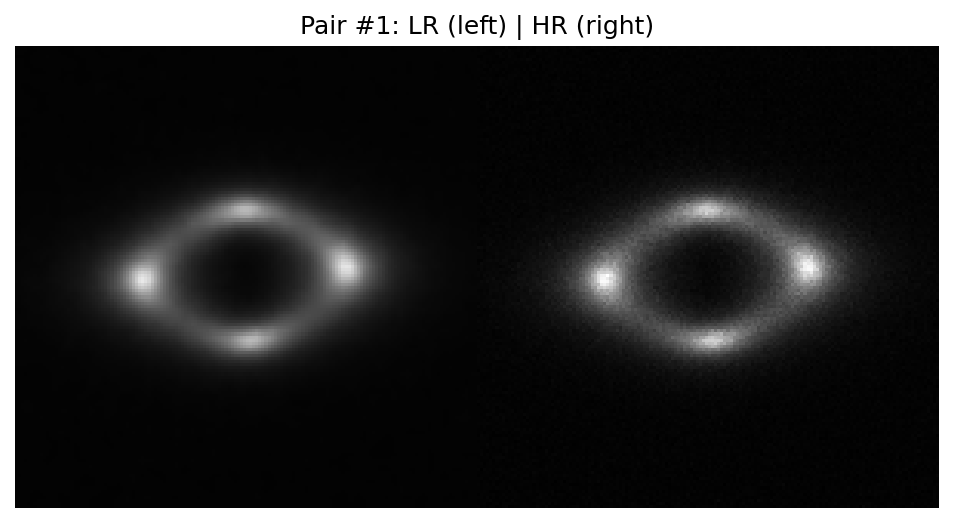

In [8]:
visualize_random_pairs_side_by_side(dataset, num_pairs=1) # visualize random pairs of LR-HR images 

In [9]:
# Check the mean, std, min, max of any random LR-HR image pair  
random_num = random.randint(0, len(dataset)-1)
lr_image, hr_image = dataset[random_num]
lr_image = lr_image.squeeze().detach().cpu().numpy()
hr_image = hr_image.squeeze().detach().cpu().numpy()
print( 'lr_image mean : ',lr_image.mean(),' std : ',lr_image.std(),' min : ',lr_image.min(),' max : ',lr_image.max())
print( 'hr_image mean : ',hr_image.mean(),' std : ',hr_image.std(),' min : ',hr_image.min(),' max : ',hr_image.max())   

    

lr_image mean :  0.058697257  std :  0.12062064  min :  0.008492822  max :  0.9451201
hr_image mean :  0.05870687  std :  0.12205327  min :  0.0  max :  1.0


In [10]:
# Create data loaders   
set_seed(HP['seed'])    
from torch.utils.data import DataLoader 

train_loader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HP['batch_size'], shuffle=False)     

##### *5.3 Model Definition*

The proposed architecture is heavily inspired by the work “SwinIR: Image Restoration Using Swin Transformer” by Liang et al. As in SwinIR, our model is composed of three components:

- **Shallow Feature Extraction Module** :A 3×3 convolutional layer extracts low-frequency features (e.g., smooth regions and broad color transitions). These shallow features serve as one of the input for the upsampling stage and help preserve overall image structure.

- **Deep Feature Extraction Module** :We use a pretrained MAE encoder to capture high-frequency details and more complex structures. Skip connections are introduced after every two encoder blocks, ensuring smooth feature flow and better gradient propagation. 

- **Upsampling/Reconstrcution Module**: Sub-pixel convolutional layers (PixelShuffle) reconstruct the final, high-resolution image from the combined output fROm shallow feature extraction module and deep feature extraction module.


In [ ]:

class ModifiedMAE_SR(nn.Module):
    def __init__(self, pretrained_model,inter_dim=8,upscale_factor=2):
        super(ModifiedMAE_SR, self).__init__()
        self.encoder = pretrained_model.encoder 
        self.patch_embed = self.encoder.patch_embed 
        self.patchify = self.encoder.patchify   
        self.cls_token = self.encoder.cls_token 
        self.pos_embed = self.encoder.pos_embed 
        self.blocks = self.encoder.blocks
        self.layer_norm = self.encoder.norm

        self.patch_unembed = nn.Linear(128, 64)
        self.unpatchify = self.encoder.unpatchify   

        self.conv_first = nn.Conv2d(in_channels=1, out_channels=inter_dim, 
                                    kernel_size=3, stride=1, padding=1)
        self.reconstruction = nn.Sequential(
            nn.Conv2d(in_channels=inter_dim,out_channels= inter_dim * (upscale_factor ** 2), 
                      kernel_size=3, stride= 1, padding=1),
            nn.PixelShuffle(upscale_factor),
            nn.Conv2d(in_channels=inter_dim, out_channels=1,
                        kernel_size=3, stride=1, padding=1),
        )
        self.conv_last = nn.Conv2d(in_channels=1, out_channels=inter_dim,
                                    kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        # x (B,1,64,64) <=? (B,C,H,W)
        
        # ----------------------------------------------------------------------
        ## Shallow Feature Extraction Module ##
        shallow = self.conv_first(x) # (B,8,64,64)

        # ----------------------------------------------------------------------
        ## Deep Feature Extraction Module ##
        x = self.patch_embed(x) # (B, 64, 128) <=> (B, seq_len, d_model) 
        x = x + self.pos_embed[:,1:,:]  # (B, 64, 128)

        # appending cls token to the input
        cls_token = self.cls_token + self.pos_embed[:,0:1,:] # (1, 1, 128)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1) # (B, 1, 128)
        x = torch.cat((cls_tokens, x), dim=1) # (B, 65, 128)

        # Process through encoder with residual every two blocks
        for i in range(0, len(self.blocks), 2):
            residual = x
            x = self.blocks[i](x)
            x = self.blocks[i+1](x)
            x = x + residual  # Residual connection
        
        x = self.layer_norm(x) # (B, 65, 128)
        
        x = x[:,1:,:] # (B, 64, 128) <=> (B, seq_len, d_model) 
        x = self.patch_unembed(x)
        x = self.unpatchify(x) # (B,64,64) <=> (B,1,64,64)

        x = self.conv_last(x) # (B,8,64,64)
        x = x + shallow # skip connection  
        
        # -----------------------------------------------------------------------
        ## Upsampling Module ## 
        x = self.reconstruction(x) # (B,1,128,128) 
        start = (192 - 150) // 2
        end = start + 150
        x = x[:, :, start:end, start:end]  # (B,1,150,150)

        return x   
   


##### *5.4 Training*

C:\Users\Admin\AppData\Local\Temp\ipykernel_11788\591773969.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load(model_path)


Trainable parameters : 817329
Training started...
Epoch [1/20],Train Loss: 0.00599709
Validation Loss: 0.00066243
Epoch [2/20],Train Loss: 0.00041075
Validation Loss: 0.00028203
Epoch [3/20],Train Loss: 0.00023876
Validation Loss: 0.00020192
Epoch [4/20],Train Loss: 0.00018105
Validation Loss: 0.00015553
Epoch [5/20],Train Loss: 0.00015420
Validation Loss: 0.00014173
Epoch [6/20],Train Loss: 0.00013955
Validation Loss: 0.00014929
Epoch [7/20],Train Loss: 0.00013067
Validation Loss: 0.00012082
Epoch [8/20],Train Loss: 0.00012281
Validation Loss: 0.00011527
Epoch [9/20],Train Loss: 0.00011731
Validation Loss: 0.00013595
Epoch [10/20],Train Loss: 0.00011383
Validation Loss: 0.00011276
Epoch [11/20],Train Loss: 0.00011210
Validation Loss: 0.00011318
Epoch [12/20],Train Loss: 0.00010736
Validation Loss: 0.00010958
Epoch [13/20],Train Loss: 0.00010907
Validation Loss: 0.00010593
Epoch [14/20],Train Loss: 0.00010486
Validation Loss: 0.00009965
Epoch [15/20],Train Loss: 0.00010159
Validation L

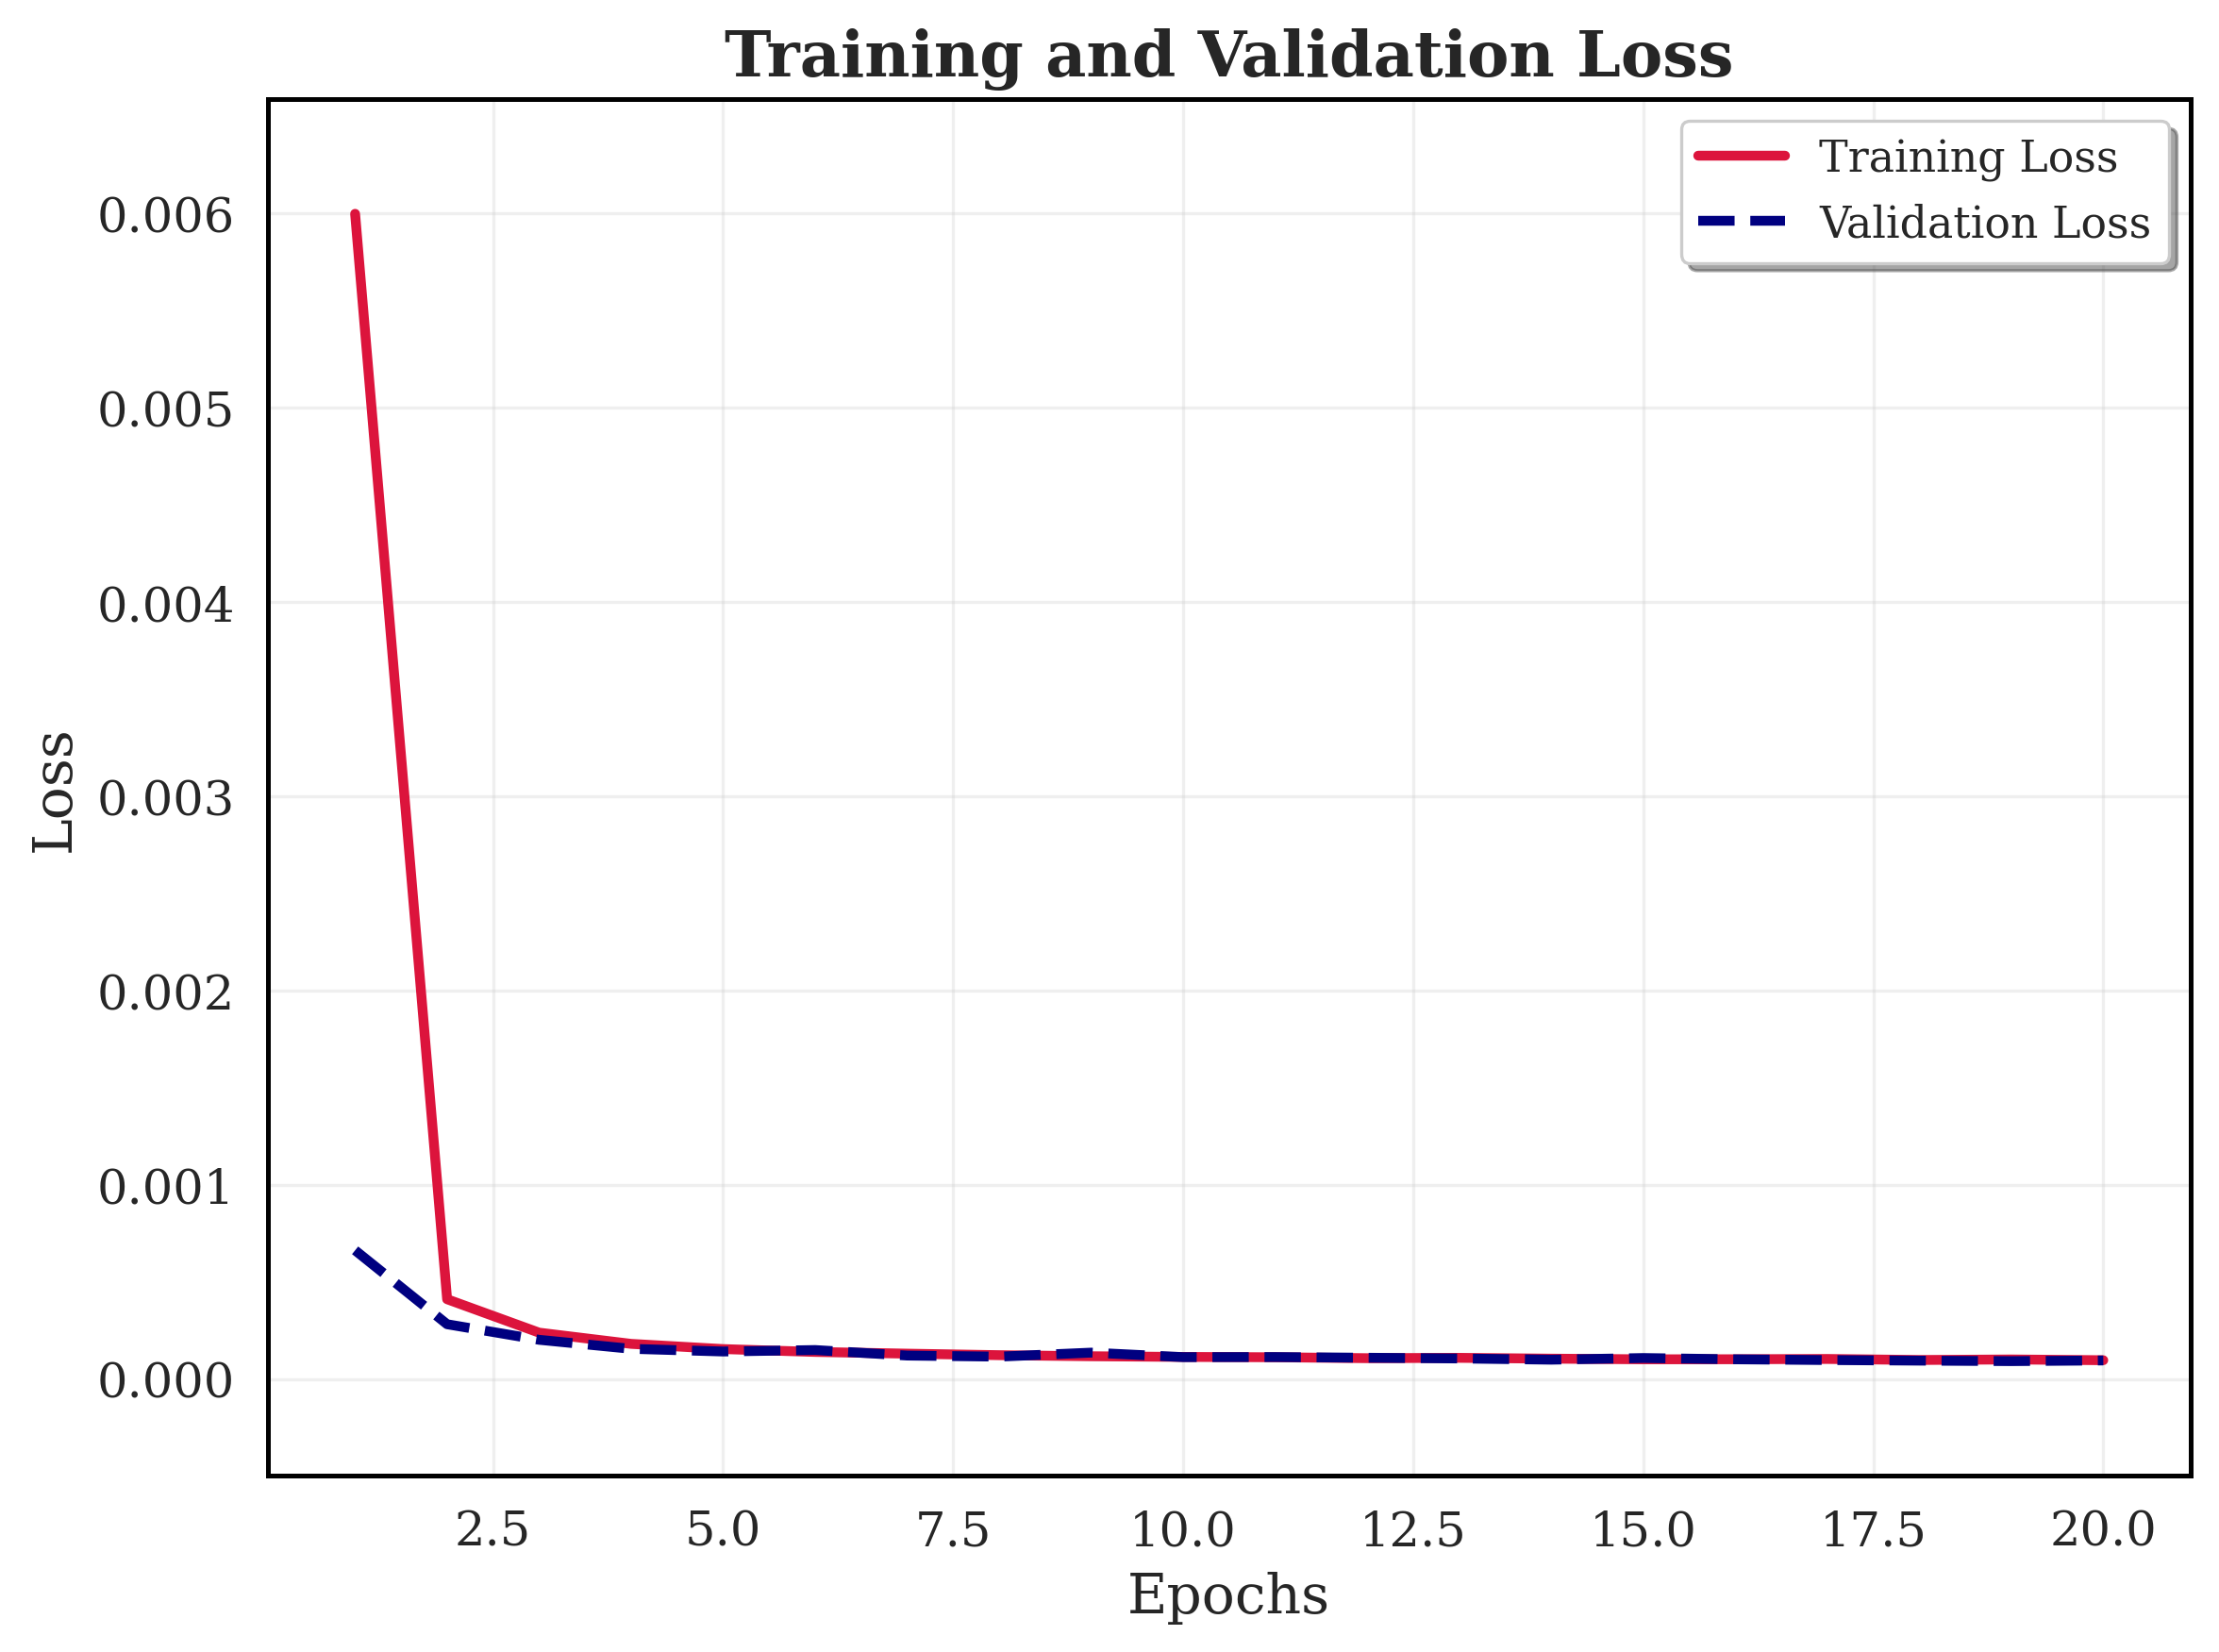

Training complete.


In [ ]:
set_seed(HP['seed'])    

pretrained_model = torch.load(model_path) 
model = ModifiedMAE_SR(pretrained_model,upscale_factor=3,inter_dim=8).to( device )
print( 'Trainable parameters :', sum(p.numel() for p in model.parameters() if p.requires_grad) )

trainer = Trainer(model,device, HP)
trainer.model_train(train_loader, val_loader)   


In [ ]:
# torch.save(model.state_dict(), 'weights/best_superresolution_model.pth') 


##### *5.4 Inference*

In [ ]:
trainer.eval_model(test_loader)

Average PSNR: 40.2389, Average SSIM: 0.9660, Average MSE: 0.000096


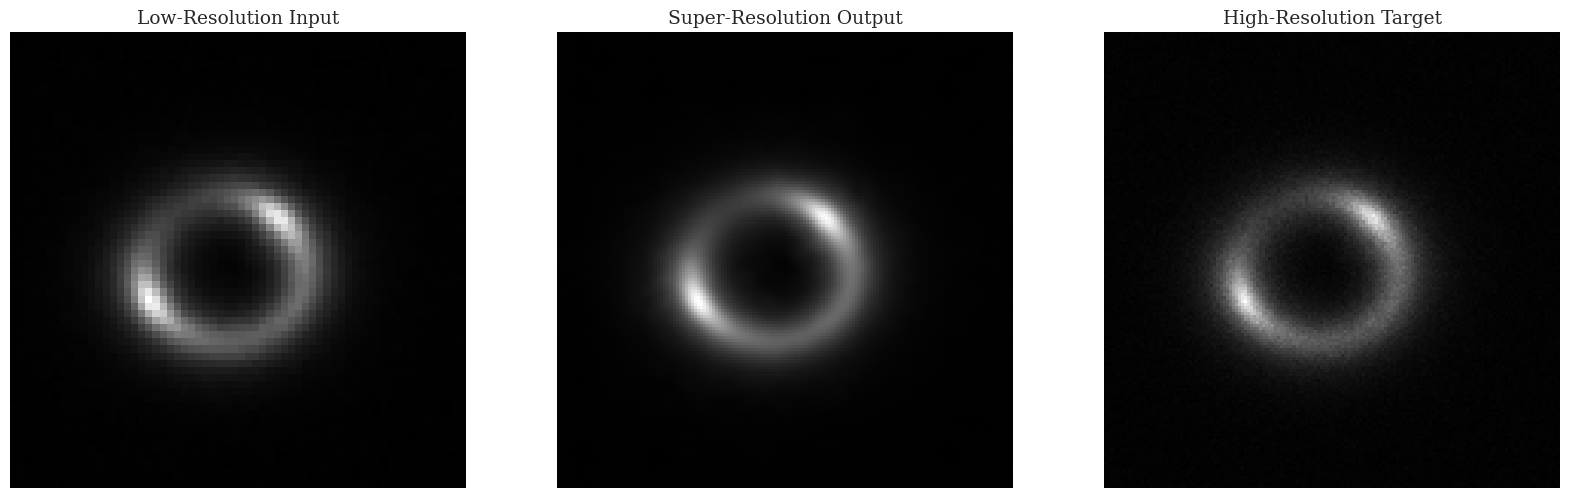

In [18]:
model.eval()

data_iter = iter(test_loader)
lr_img, hr_img = next(data_iter)

lr_img = lr_img.to(device) # low-resolution image  (B,1, 75, 75)
hr_img = hr_img.to(device) # high-resolution image (B,1,150,150)
# print( 'lr_img shape : ',lr_img.shape)  

with torch.no_grad():
    sr_img = model(lr_img) # super-resolved image

lr_np = lr_img.cpu().squeeze().numpy() # (B, 75, 75)
hr_np = hr_img.cpu().squeeze().numpy() # (B,150,150)
sr_np = sr_img.cpu().squeeze().numpy() # (B,150,150)

# Visualize the images  
random_num = random.randint(0, lr_np.shape[0]-1)
visualize_images(lr_np[random_num], sr_np[random_num], hr_np[random_num])